# Cluster Analysis --- generate word clusters with k-means algorithm for application of NLP

Local minima on cost function is common in k-mean algorithm because the algorithm is sensitive to the random initialization of centroids.

Solution: Run multiple times to choose the lowest cost possible.

Before doing k-means algorithm, we should notice that k-means is sensitive to the scale of the data, if data itself
is too big (e.g., ~1e6), then the euclidean distance between a centroid and any datapoint will scale to ~1e12. Therefore,
before doing k-means, it's always safe to first normalize the data.

Secondly, k-means is sensative to large dataset since the cost is the summation of all euclidean distances. Therefore,
we can scale down the cost by dividing the cost by D and N.

Finally, there is no "overfitting" for k-means algo even if k(cluster number) is extremely large (k~N), because "overfitting" only exists in the supervised ml problems. "Overfitting" means model is too fit for training dataset, but not quite fit for test dataset. But we should always be careful when choosing k.


This project first dive into the mathematics behind k-means algorithm as well as methods for evaluating k-means algorithms: DBI index, purity. Then use k-means algorithm to generate word clusters based on Wikipedia data.

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.manifold import TSNE
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
import re
import time
import warnings
warnings.simplefilter('ignore')

In [9]:
class Initialization():
    
    
    def __init__(self,N,D):
        
        self.D = D
        self.N = N
        self.Y = None
        self.X = None
        
    def data_initialization(self,centroids):
        
        N = self.N
        D = self.D  
        X = np.zeros((N,D))
        Y = np.zeros(N)
        L = len(centroids)
        indx = int(N/L)
        for i in range(L):           
            if i == L - 1:
                X[i*indx:,:] = np.random.randn(indx,D) + centroids[i]
                Y[i*indx:] = i
            else:
                X[i*indx:(i+1)*indx,:] = np.random.randn(indx,D) + centroids[i]
                Y[i*indx:(i+1)*indx] = i
        self.X = X
        self.Y = Y
    
    def data_visualization(self,centroids):
        
        self.data_initialization(centroids)
        
        X = self.X
        D = self.D
        
        if D == 2:
            plt.scatter(X[:,0],X[:,1])
            for cent in centroids:
                plt.scatter(cent[0],cent[1],marker='x',c='r',s=30)
            plt.title("Raw data before k-means",fontsize=14)
            plt.show()
        
        elif D > 2:
            tsne = TSNE()
            Z = tsne.fit_transform(X)
            plt.scatter(Z[:,0],Z[:,1])
            plt.title("Raw data before k-means",fontsize=14)
            plt.show()   
            
        else:
            
            print("Dimension of data cannot be 1.")          

In [10]:
class k_means():
    
    def __init__(self,beta,N,epochs,num_of_clusters,data):
        
        self.costs = None
        self.beta = beta
        self.epochs = epochs
        self.N = N
        self.num_of_clusters = num_of_clusters
        self.data = data
        self.W = None
        self.clusters = None
        
        if self.data.shape[1] > 2:   
            print("For data of 3D or higher dimensions, there are no plots displayed for each epoch.\
                  Please set 'plot' attribute to False in the 'train' function.")
        
    def color_generator(self,num):
        
        e = ['a','b','c','d','e','f','0','1','2','3','4','5','6','7','8','9']
        colors = []
        
        for _ in range(num):
            hex_c = "#"+''.join([e[i] for i in np.random.choice(len(e),6)])
            colors.append(hex_c)
        
        return colors
        
    def train(self,soft,plot):
 
        data = self.data
        num_of_clusters = self.num_of_clusters
        N = self.N
        beta = self.beta
        clusters = self.clusters
        self.costs = []
        inds = np.random.choice(N,num_of_clusters,replace=False)
        clusters = data[inds,:]
        
        #define weights for soft k-means
        W = np.zeros((N,num_of_clusters))
              
        
        if soft == False:
            plt.figure(figsize=(6,150))
            random_colors = self.color_generator(num_of_clusters)
            for it in tqdm(range(self.epochs)):
                self.clusters_lst = [[] for _ in range(num_of_clusters)]
                for i in range(N):                
                    min_distance = np.inf
                    min_j = 0
                    for j in range(num_of_clusters):                 
                        dist = self.distance(data[i,:],clusters[j,:])
                        if dist<min_distance:
                            min_distance = dist
                            min_j = j
                    self.clusters_lst[min_j].append(i)
                if plot == True and data.shape[1] == 2:
                    for i in range(len(self.clusters_lst)):
                        plt.subplot(self.epochs,1,it+1)
                        plt.scatter(data[self.clusters_lst[i],0],data[self.clusters_lst[i],1],c=random_colors[i])
                        plt.title("Clusters after hard-k means algorithm it=%s" % it)
                cost = self.cost_function_hard(clusters)
                self.costs.append(cost)
                
                #redefine the new clusters for the next iteration
                for indx,indx_lst in enumerate(self.clusters_lst):
                    clusters[indx,:] = data[indx_lst,:].mean(axis=0)
            
            plt.savefig("./cluster_demo.png")
            self.clusters = clusters
            
            
        

        else:
            
            plt.figure(figsize=(6,150))
            random_colors = self.color_generator(num_of_clusters)
            for it in tqdm(range(self.epochs)):
                # We plot each epoch
                if plot==True and data.shape[1]==2:
                    W_certain = np.zeros_like(W)
                    for i in range(N):
                        j = W[i,:].argmax()       
                        W_certain[i,j] = 1      
                    C = W_certain.shape[1]
              

                    for i in range(C):
                        indx = np.where(W_certain[:,i]==1)
                        plt.subplot(self.epochs,1,it+1)
                        plt.scatter(self.data[indx,0],self.data[indx,1],c=random_colors[i])
                        plt.title("Clusters after soft-k means algorithm it=%s" % it)
                
                
                for i in range(N):
                    
                    denominator = np.sum(np.exp(-beta*self.distance(data[i,:],clusters[m,:])) for m in range(num_of_clusters))
                    for j in range(num_of_clusters):
                        W[i,j] = np.exp(-beta*self.distance(data[i,:],clusters[j,:])) / denominator 
                cost = self.cost_function_soft(W,data,clusters)
                self.costs.append(cost)

                #redefine the new clusters for the next iteration
                for i in range(num_of_clusters):
                    clusters[i,:] = W[:,i].dot(data)/np.sum(W[:,i])    
                
            plt.savefig("./cluster_demo.png")

            self.W = W
            self.clusters = clusters
        
    def cost_function_soft(self,W,X,C):  
        
        cost = 0 

        for i in range(self.num_of_clusters):

            dist_arr = np.array([self.distance(X[j,:],C[i,:]) for j in range(self.N)])
            avg_cost = W[:,i].dot(dist_arr)/self.N 
            cost+=avg_cost
        
        cost/=self.num_of_clusters
            

        return cost 
    
    def cost_function_hard(self,C):
        
        cost=0
        for indx,indx_lst in enumerate(self.clusters_lst):
            dist_arr = np.array([self.distance(self.data[j,:],C[indx,:]) for j in indx_lst])
            avg_cost = dist_arr.sum()/len(indx_lst)
            cost+=avg_cost
        cost/=len(self.clusters_lst)
        return cost

    def distance(self,X,Y):
        
        """
        We use Euclidean distance instead of Cosine distance here because let's consider two vectors:
        
        [1,2,3] and [-1000,-1000,1000], their cosine distance is zero but these two points have a
        
        large euclidean distance. They should not be in the same cluster.
              
        """
        dis = np.sqrt((X-Y).dot((X-Y)))
        
        return dis
    
    def Elbow(self):       
        clusters = self.clusters
        data = self.data
        W = self.W
        N,k = W.shape
        distortion = 0
        for i in range(N):
            for j in range(k):
                dis = data[i,:] - clusters[j,:]
                distortion+=W[i,j]*dis.dot(dis)
        return distortion
    
    def DBI(self):
        
        """
        
        This method computes DBI of SOFT-K-MEANS algo. Soft-k-means algo needs weights when computing DBI.
        
        DBI is an internal validation method (no need of true labels) for determining the best model of k-means algo.
        
        It has two usage:
        
        (1) With a fixed cluster number k, sometimes the model reaches local minima, meaning the model is not
        
        the best one for clustering. In this case, in addition to observe the cost value (we need to get a final cost
        as low as possible), we can also observe DBI, since the optimal model (with global minima) has the lowest DBI.
        
        (2) We can also use DBI to roughly determine the best cluster number k. The optimal-k model could yield the lowest DBI,
        
        though we cannot solely rely on DBI to determine k because let's consider an extreme case where k = N (each point is a
        
        cluster), then DBI would be zero in that case. Nonetheless, DBI can determine an optimal k in a certain range of k.
        
        To determine k more accurately, we should also resort to elbow method.
        
        
        Note: the numerator of DBI can be viewed as the deviation of datapoint from centroids. A best case of clustering
        
        would be a smallest deviation(numerator) combining with a biggest centroid distance (denominator), which yields a lowest DBI.
        
        
        
        """
        
        W = self.W
        clusters = self.clusters
        data = self.data
        N = self.N
        
        DBI_total = []
        for cluster_indx_i, cluster_i in enumerate(clusters):
            
            k_sigma = 0
            for data_indx_i, x in enumerate(data):
                k_sigma+=W[data_indx_i,cluster_indx_i]*self.distance(x,cluster_i)
            k_sigma/=N
            
            
            j_sigma = 0
            DBIs = []
            for cluster_indx_j, cluster_j in enumerate(clusters):
                
                if cluster_indx_i == cluster_indx_j:
                    
                    continue
                
                for data_indx_j, x in enumerate(data):
                    j_sigma+=W[data_indx_j,cluster_indx_j]*self.distance(x,cluster_j)
                
                j_sigma/=N

                DBI = (k_sigma+j_sigma)/self.distance(cluster_i,cluster_j)
                DBIs.append(DBI)
        
            DBI_max = np.max(DBIs)
            DBI_total.append(DBI_max)
        
        overall_DBI = np.sum(DBI_total)/self.num_of_clusters
        
        return overall_DBI
                
    
    def purity(self,label):
        
        """
        Purity is another method to evaluate a k-means clustering, but it requires true labels. Therefore, it is
        
        called an external validation method. If we have true labels, we can also do supervised machine learning
        
        for classification problem.
        """
        
        W = self.W
        clusters = self.clusters
        data = self.data
        N = self.N   
        indx_lst = [[] for _ in range(self.num_of_clusters)]
        label_count = []
        for i in range(N): 
            indx_lst[W[i,:].argmax()].append(i)
        
        for k in range(self.num_of_clusters):
            
            label_count_per_k = []
            
            for i in range(self.num_of_clusters):
                
                c = 0 
                
                for j in np.where(label==i)[0]:
                                       
                    if j in indx_lst[k]:

                        c+=1
                
                label_count_per_k.append(c)
                
            label_count.append(np.max(label_count_per_k))
        
        purity = np.sum(label_count)/N
        
        return purity
            
        
    
    def plot_clusters(self,soft,uncertainty=False):
        
        
        if soft == False:
            
            C = len(self.clusters_lst) 
            random_colors = self.color_generator(self.num_of_clusters)
            plt.figure(figsize=(10,10))
            if self.data.shape[1] > 2:                
                    tsne = TSNE()
                    Y = tsne.fit_transform(self.data)               
                    for i in range(C):
                        plt.scatter(Y[self.clusters_lst[i],0],Y[self.clusters_lst[i],1],c=random_colors[i]) 
                        plt.title("Clusters after hard-k means algorithm",fontsize=14)
                    plt.savefig("./hard_demo.png")
            else:

                for i in range(C):
                    plt.scatter(self.data[self.clusters_lst[i],0],self.data[self.clusters_lst[i],1],c=random_colors[i]) 
                    plt.title("Clusters after hard-k means algorithm",fontsize=14)
                plt.savefig("./hard_demo.png")
        
        else:
            
            # The uncertainty case only can be used when we have three clusters, because three clusters correspond to
            # R,G,B three base colors.
            if self.W.shape[1] == 3 and uncertainty == True:
                plt.figure(figsize=(10,10))
                plt.scatter(self.data[:,0],self.data[:,1],c=self.W)
                plt.title("Clusters after soft-k means algorithm",fontsize=14)
                plt.savefig("./soft_uncertainty_demo.png")

            else:
                plt.figure(figsize=(10,10))
                W_certain = np.zeros_like(self.W)
                for i in range(self.N):
                    j = self.W[i,:].argmax()       
                    W_certain[i,j] = 1      
                C = W_certain.shape[1]
                
                random_colors = self.color_generator(self.num_of_clusters)


                if self.data.shape[1] > 2:

                    tsne = TSNE()
                    Y = tsne.fit_transform(self.data)               
                    for i in range(C):
                        indx = np.where(W_certain[:,i]==1)
                        plt.scatter(Y[indx,0],Y[indx,1],c=random_colors[i]) 
                        plt.title("Clusters after soft-k means algorithm",fontsize=14)
                    plt.savefig("./soft_demo.png")



                else:
                    for i in range(C):
                        indx = np.where(W_certain[:,i]==1)
                        plt.scatter(self.data[indx,0],self.data[indx,1],c=random_colors[i])
                        plt.title("Clusters after soft-k means algorithm",fontsize=14)
                    plt.savefig("./soft_demo.png")




## Toy example on self-defined k-means algorithm

### Generate toy data for testing k-means

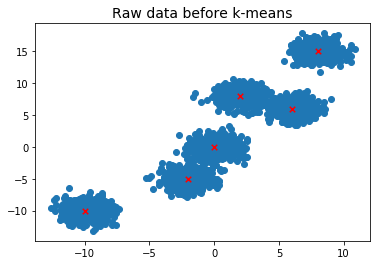

In [11]:
data = Initialization(3000,2)
# define six initial centroids
centroids = [np.array([0,0]),np.array([-10,-10]),np.array([-2,-5]),np.array([6,6]),np.array([2,8]),np.array([8,15])]
data.data_visualization(centroids)
N = data.N
D = data.D
X = data.X
Y = data.Y

### Test k-means 

Firstly we choose soft-k-means to test. Practically, soft-k-means performs better than hard k-means.

From data generated above, we know that data we want to be clustering has 6 clusters.

We also **plot** the process of clustering as data is being clustered for each epoch. In this way, we can clearly see how data is clustered. Sometimes, when we reach local minima, from the plots, we are able to see how we reach it and accordingly know that we need to rerun the algorithm in order to reach global minima.

Run 20 epochs/iterations.

100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


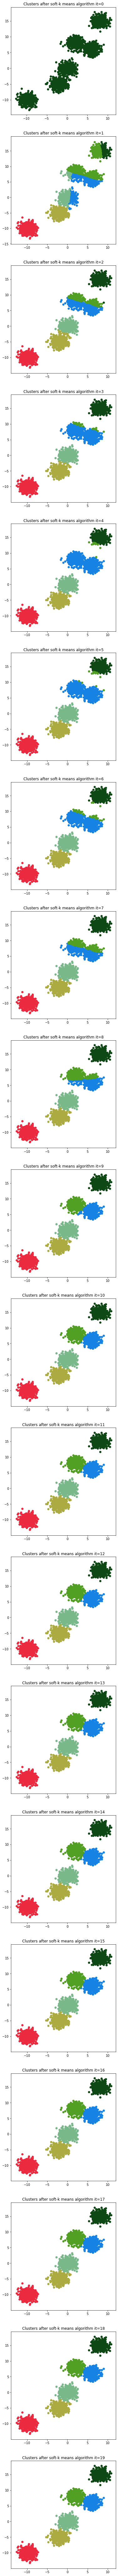

In [26]:
model = k_means(beta=1.0,N=N,epochs=20,num_of_clusters=6,data=X)
model.train(soft=True,plot=True)

Plot cost values per epoch

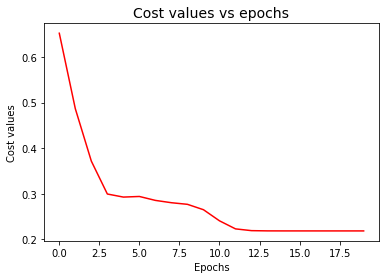

In [27]:
plt.plot(model.costs,'r')
plt.title("Cost values vs epochs",fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Cost values")
plt.show()

#### Running examples:

#### The following shows some previous running examples.

According to the toy data generated before, k-means algorithm should classify six clusters on the toy data
because we generate random six clusters on purpose in order to test the algorithm.

*six clusters are labeled red*

<img src="https://i.imgur.com/Dbd7QG8.png" width="600" align="center"/>

**Example 1**

Below is the process of k-means clustering, we show the plots of iteration = 0, 1, 2, 3, 4, 5, 6, 17, 18, 19. As we can see, k-means algorithm does not classify the six clusters properly. In other words, the algorithm reaches local minima when minimizing the cost function. The lowest cost for this example is 0.3152

<br>
<img src="https://i.imgur.com/XICheRm.png"  width="300" align="left"/>
<img src="https://i.imgur.com/XWWtDDN.png"  width="300" align="left"/>
<img src="https://i.imgur.com/SsF9Tmz.png"  width="300" align="left"/>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<img src="https://i.imgur.com/kNlQ9H3.png"  width="300" align="left"/>
<img src="https://i.imgur.com/lF0D9Ea.png"  width="300" align="left"/>
<img src="https://i.imgur.com/IZVxPS1.png"  width="300" align="left"/>
<img src="https://i.imgur.com/cMhCuHp.png"  width="300" align="left"/>
<img src="https://i.imgur.com/FYywZM1.png"  width="300" align="left"/>
<img src="https://i.imgur.com/7oXZhpc.png"  width="300" align="left"/>

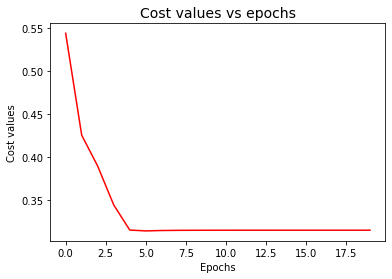

In [11]:
plt.plot(model.costs,'r')
plt.title("Cost values vs epochs",fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Cost values")
plt.show()

**Example 2**

We run k-means again.

We show the plots of iteration = 0, 1, 2, 3, 4, 5, 6, 17, 18, 19. As we can see, still no luck this time. k-means algorithm improperly classifies data into six clusters in a different way than the first example. This is because the **algorithm reaches another different local minima** when minimizing the cost function. The lowest cost for this example is 0.2836

<br>
<img src="https://i.imgur.com/yHpcc4Z.png"  width="300" align="left"/>
<img src="https://i.imgur.com/ktiKZpt.png"  width="300" align="left"/>
<img src="https://i.imgur.com/mUR6oOj.png"  width="300" align="left"/>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<img src="https://i.imgur.com/Crp7CAE.png"  width="300" align="left"/>
<img src="https://i.imgur.com/1JoFkD0.png"  width="300" align="left"/>
<img src="https://i.imgur.com/Kih0vk3.png"  width="300" align="left"/>
<img src="https://i.imgur.com/sXaodQz.png"  width="300" align="left"/>
<img src="https://i.imgur.com/OYkWmHm.png"  width="300" align="left"/>
<img src="https://i.imgur.com/51AYDiW.png"  width="300" align="left"/>

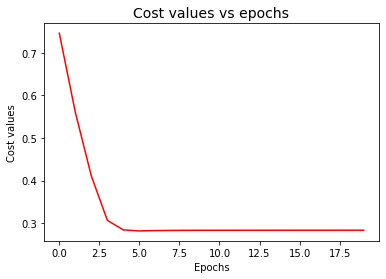

In [14]:
plt.plot(model.costs,'r')
plt.title("Cost values vs epochs",fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Cost values")
plt.show()

**Example 3**

We run k-means again.

We show the plots of iteration = 0, 1, 2, 3, 4, 5, 6, 17, 18, 19.This time, k-means algorithm properly classifies data into six clusters. This is because the algorithm reaches another different **global minima** when minimizing the cost function. The lowest cost for this example is 0.2197

<br>
<img src="https://i.imgur.com/lT5ziwl.png"  width="300" align="left"/>
<img src="https://i.imgur.com/uHY7WyN.png"  width="300" align="left"/>
<img src="https://i.imgur.com/DK2RQKT.png"  width="300" align="left"/>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<img src="https://i.imgur.com/UnmqfEf.png"  width="300" align="left"/>
<img src="https://i.imgur.com/5I6tKuA.png"  width="300" align="left"/>
<img src="https://i.imgur.com/HAa3zgI.png"  width="300" align="left"/>
<img src="https://i.imgur.com/a8HPQHp.png"  width="300" align="left"/>
<img src="https://i.imgur.com/phZ8W7h.png"  width="300" align="left"/>
<img src="https://i.imgur.com/wyoi6N0.png"  width="300" align="left"/>

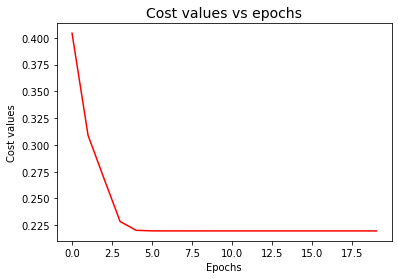

In [86]:
plt.plot(model.costs,'r')
plt.title("Cost values vs epochs",fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Cost values")
plt.show()

Local minima on cost function is common in k-mean algorithm because the algorithm is sensitive to the random initialization of centroids.

Solution: Run multiple times to choose the lowest cost possible.

### Ways to determine the number of clusters (Elbow, DBI, purity)

The above example is based on a toy dataset. We know exactly how many clusters we have before doing k-means. 

In practice, we typically don't know how many clusters we have on the dataset before doing k-means. And this is actually why we use k-means. The gist of k-means is to detect the latent similiarities behind the dataset and it is widely used when we want to get a general/first sense of the dataset before doing subsequent work.

Therefore, we need to decide how many clusters (k) for k-means to classify on the dataset. We use Elbow method, Davies–Bouldin index (DBI), and purity to decide the number of clusters k.



We still use the toy dataset above to show how to decide k. However, we pretend that we don't know the dataset has six clusters. Therefore, we give a range of 2 - 15 clusters (k=2-15) for k-means to classify and evaluate under which number does k-means performs the best by Elbow method, DBI, and purity.

In [18]:
SS_within= []
dbis = []
purities = []
retry_times = 8
models = []
for k in tqdm(range(2,16)):
    local_model = None
    cost_min = np.inf
    # Retry the k-means algorithm on a certain k value for multiple times to avoid the local minima situation
    # Whichever yields the lowest cost is chosen to be the model
    for _ in range(retry_times):
        model = k_means(beta=1.0,N=N,epochs=20,num_of_clusters=k,data=X)
        model.train(soft=True,plot=False)
        c = model.costs[-1]
        if c < cost_min:
            cost_min = c
            local_model = model
        
    dbis.append(local_model.DBI())
    SS_within.append(local_model.Elbow())
    purities.append(local_model.purity(Y))
    models.append(local_model)


100%|██████████| 14/14 [16:02<00:00, 99.05s/it]


<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

#### Elbow Result

Generally, as cluster number k increases, distortion goes down. The gist of Elbow method is to find a cluster number k beyond which distortion does not decreases significantly. Beyond the Elbow point, the benefit of increasing cluster number k starts to tail off. In other words, we gain much more less benefit by increasing cluster number k than before. Occasionally, as k increases, distortion goes up a bit, which is probably because in that specific case of k, the model reaches a local minima instead of global minima.

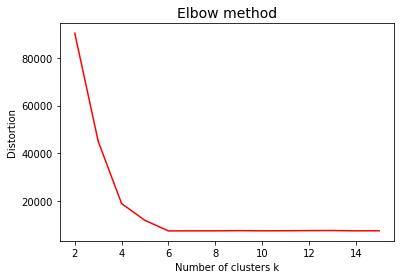

In [19]:
plt.plot(range(2,16),SS_within,'r')
plt.title("Elbow method",fontsize=14)
plt.xlabel("Number of clusters k")
plt.ylabel("Distortion")
plt.show()

#### DBI Result

DBI can be used to roughly determine the best cluster number k. The optimal model could yield the lowest DBI,
though we cannot solely rely on DBI to determine k. Because let's consider an extreme case where k = N (each point is a cluster), then according to definition, DBI would be zero in that case. Nonetheless, DBI can help to determine the k value, and the optimal model should have low DBI (not necessarily the lowest). To determine k more accurately, we still need to refer to Elbow method and purity.

Q: Why the model with a good cluster number k should yield low DBI instead of high DBI?

A: According to the mathematical definition of DBI, the numerator of DBI can be viewed as the deviation of data points from centroids; the denominator can be viewed as the distance between two different clusters. A good clustering would be a small deviation(numerator) combining with a large centroid distance (denominator), which yields a low DBI.
        

        
        

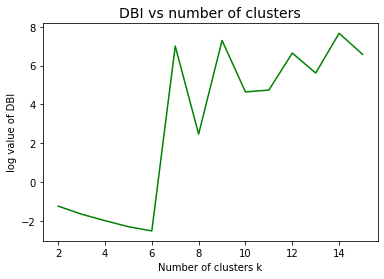

In [20]:
plt.plot(range(2,16),np.log(dbis),'g')
plt.title("DBI vs number of clusters",fontsize=14)
plt.xlabel("Number of clusters k")
plt.ylabel("log value of DBI")
plt.show()

#### Purity Result

Purity is an external validation method for evaluating k-means because it requires true labels. 

Purity is similar to accuracy test in supervised machine learning problem. Purity examines whether the data point is classified into the correct cluster. In order to know if the data point is in the right cluster, we need to know the label of this data point beforehand, which might not be accessible somtimes when doing cluster analysis.

The best purity that a model could get is 1, which means all data points are clustered into the correct labels.

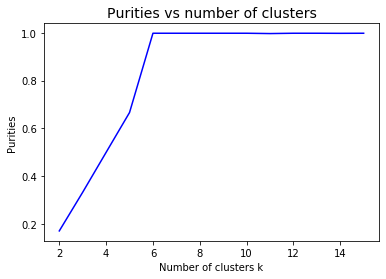

In [21]:
plt.plot(range(2,16),purities,'b')
plt.title("Purities vs number of clusters",fontsize=14)
plt.xlabel("Number of clusters k")
plt.ylabel("Purities")
plt.show()

From the Elbow graph, DBI graph and purity graph above, we can see there is no significant decrease after k = 6, and the purity value is high at k = 6 as well as DBI is the lowest at k = 6. Therefore, k = 6 is a good cluster number, which complies to what we know: the toy dataset was generated with six clusters. The gist of k-means is to let the algorithm to do its job, without being supervised by labels. In other words, let the algorithm to "feel" the data, and decide how many clusters can capture the latent similarities behind the data.

Q: Why wouldn't 4 be a good cluster number?

A: At first glance of the Elbow graph, the slope after k = 4 becomes much more flat. However, we can also see that we can still gain a lot of benefit after k = 4. We don't gain mcu benefit until k = 6. Besides, DBI at k = 4 is not as low as that at k = 6; purity value is unacceptably low at k =4 as well (only around 50%). Therefore, k = 6 is a much better cluster number than 6.

Q: Why do we start at k = 2?

A: There is no siginficant meaning of clustering data if we start at k = 0 or k = 1.

#### Results of the model with the optimal k value, k = 6

The model's DBI is 0.08133510820782104. The model's purity is 0.9976666666666667.


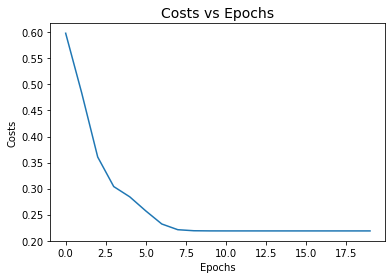

In [22]:
# model No.4 corresponds to k = 6 because we start at k = 2
plt.plot(models[4].costs)
plt.xlabel("Epochs")
plt.ylabel("Costs")
plt.title("Costs vs Epochs",fontsize=14)
print("The model's DBI is {}. The model's purity is {}.".format(dbis[4],purities[4]))
plt.show()


Plot the clusters after k-means

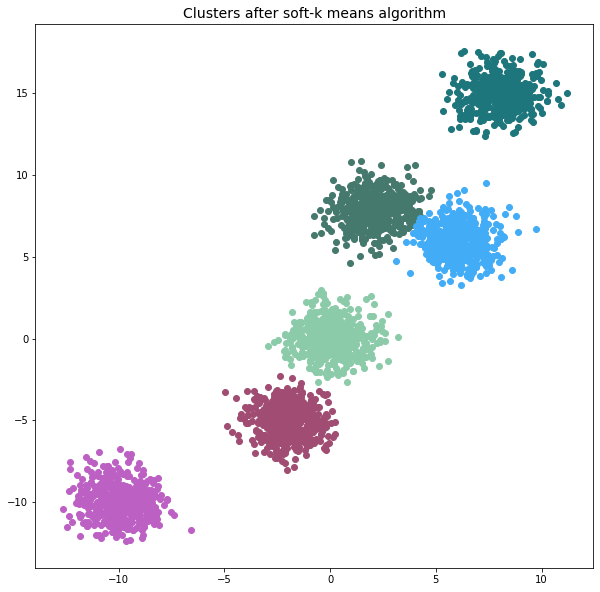

In [23]:
models[4].plot_clusters(soft=True,uncertainty=False)

## What's the difference between hard k-means algorithm and soft k-means algorithm?

Hard k-means labels each point as belonging to one cluster with 100% certainty. It is like assigning a final and certain answer to the question of “Which cluster does this point belong to?”

Whereas, soft k-means takes into consideration the fact that there are other clusters which a point may also belong to. In other words, it is not a hard 0/1 problem now, it is instead a "soft" problem of probability. Each point has a list of probabilities each of which describes a certain likelihood that this point belongs to a certain cluster. For example, if we have 500 data points with an intialization of 3 clusters, then for soft k-means, there will be a 500x3 probability matrix that acts as the weight factor when doing the cluster analysis. The way to measure how probable a data point belongs to a certain cluster is softmax function.

### Let's actually visualize the difference between the hard k-means and the soft k means.

*In this example, we will be using a 2-dimensional toy dataset with 3 pre-assigned clusters. The dataset has 900 data points.*

#### Generate the dataset

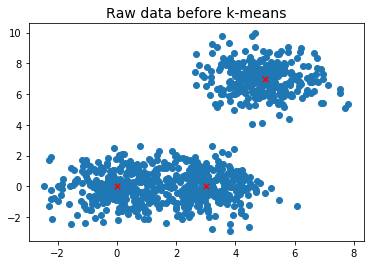

In [200]:
data = Initialization(900,2)
centroids = [np.array([0,0]),np.array([5,7]),np.array([3,0])]
data.data_visualization(centroids)
N = data.N
D = data.D
X = data.X
Y = data.Y

#### Use k-means to do cluster analysis

#### *hard k-means*








  0%|          | 0/20 [00:00<?, ?it/s]






 10%|█         | 2/20 [00:00<00:01, 14.23it/s]






 20%|██        | 4/20 [00:00<00:01, 14.12it/s]






 30%|███       | 6/20 [00:00<00:01, 13.59it/s]






 40%|████      | 8/20 [00:00<00:00, 12.80it/s]






 50%|█████     | 10/20 [00:00<00:00, 13.66it/s]






 65%|██████▌   | 13/20 [00:00<00:00, 15.55it/s]






 75%|███████▌  | 15/20 [00:01<00:00, 14.91it/s]






 85%|████████▌ | 17/20 [00:01<00:00, 15.48it/s]






100%|██████████| 20/20 [00:01<00:00, 17.36it/s]

<Figure size 432x10800 with 0 Axes>

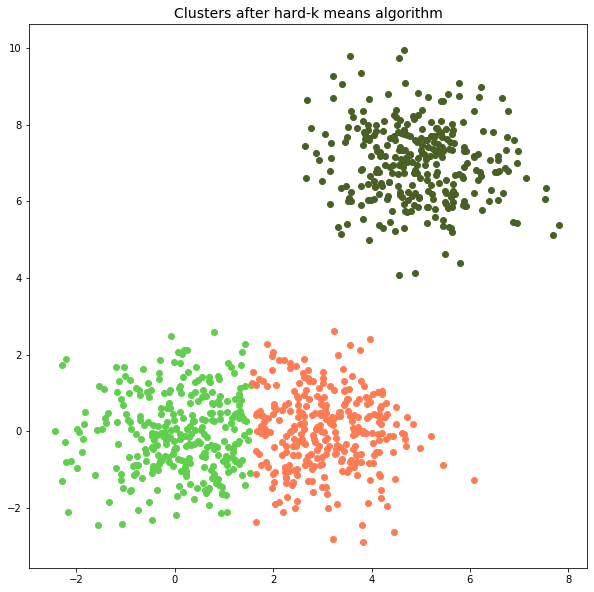

In [253]:
model = k_means(beta=1.0,N=N,epochs=20,num_of_clusters=3,data=X)
model.train(soft=False,plot=False)
model.plot_clusters(soft=False,uncertainty=False)

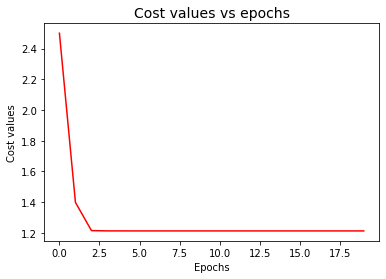

In [255]:
plt.plot(model.costs,'r')
plt.title("Cost values vs epochs",fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Cost values")
plt.show()

As we can see from the plot below, after 20 iterations, k-means algorithm properly classifies data into three clusters. The lowest cost for this example is 1.2128


<img src="https://i.imgur.com/yKKuYE7.png"  width="500" align="center"/>


#### *soft k-means*








  0%|          | 0/20 [00:00<?, ?it/s]






 10%|█         | 2/20 [00:00<00:01, 14.29it/s]






 20%|██        | 4/20 [00:00<00:01, 14.43it/s]






 30%|███       | 6/20 [00:00<00:00, 15.23it/s]






 40%|████      | 8/20 [00:00<00:00, 15.84it/s]






 55%|█████▌    | 11/20 [00:00<00:00, 17.17it/s]






 65%|██████▌   | 13/20 [00:00<00:00, 17.67it/s]






 75%|███████▌  | 15/20 [00:00<00:00, 17.52it/s]






 85%|████████▌ | 17/20 [00:00<00:00, 17.80it/s]






 95%|█████████▌| 19/20 [00:01<00:00, 17.47it/s]






100%|██████████| 20/20 [00:01<00:00, 17.13it/s]

<Figure size 432x10800 with 0 Axes>

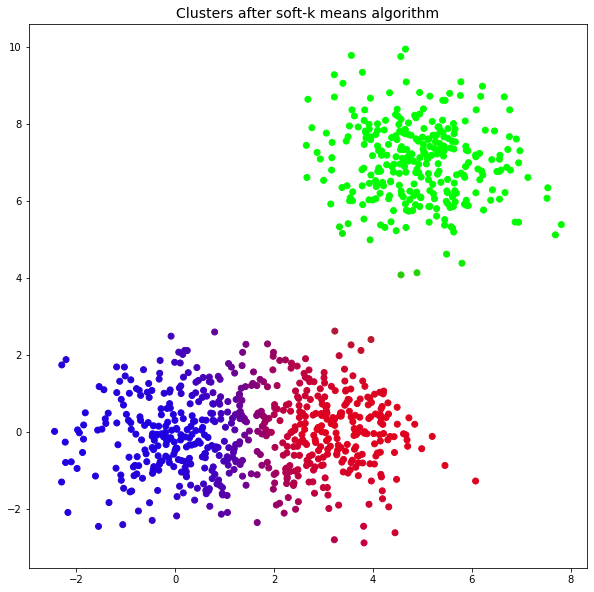

In [267]:
model = k_means(beta=1.0,N=N,epochs=20,num_of_clusters=3,data=X)
model.train(soft=True,plot=False)
model.plot_clusters(soft=True,uncertainty=True)

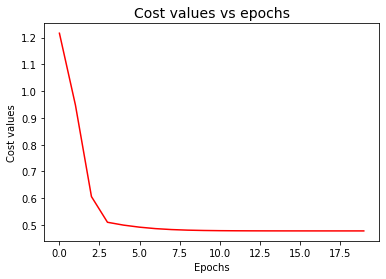

In [268]:
plt.plot(model.costs,'r')
plt.title("Cost values vs epochs",fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Cost values")
plt.show()

As we can see from the plot below, after 20 iterations, k-means algorithm properly classifies data into three clusters. Meanwhile, we can clearly see the uncertainty in the plot. Let's carefully examine the two clusters at the bottom left. From left to right, the intersection between the two clusters presents a gradual change in color from blue to red. This clearly illustrates the concept of "soft" k-means: Each point has a list of probabilities each of which describes a certain likelihood that this point belongs to a certain cluster. In other words, purely red points may belong to the right cluster, purely blue points may belong to the left cluster, whereas purple points in the middle may halfly belong to the left and halfly belong to the right. And there isn't just one kind of purple, there are various kinds. Therefore, it is not a binary(0/1) problem anymore, It is a continuous(probability) problem. The lowest cost for this example is 0.4779.

In practice, we tend to use soft k-means more because soft k-means generally yields a better result when doing cluster analysis.

<img src="https://i.imgur.com/ZKI8jTP.png" width="500" align="center"/>

## Three kinds of dataset which may fail on the k-means algorithm

1. Concentric circles.

2. elongated data: k-means tends to solve spherical problems rather than ellipitical problems.
   
3. dataset with largely unbalanced clusters.

### Dataset 1: Concentric circles

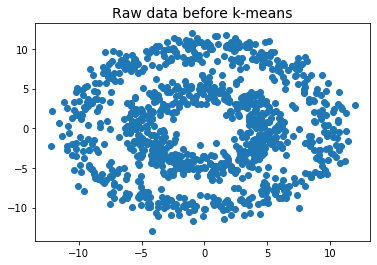

In [282]:
R_inner = np.random.randn(500) + 5
theta = 2*np.pi*np.random.random(500)
X_inner = np.concatenate([[R_inner*np.cos(theta),R_inner*np.sin(theta)]]).T

R_outer = np.random.randn(500) + 10
theta = 2*np.pi*np.random.random(500)
X_outer = np.concatenate([[R_outer*np.cos(theta),R_outer*np.sin(theta)]]).T

X = np.concatenate((X_inner,X_outer))
plt.scatter(X[:,0],X[:,1])
plt.title("Raw data before k-means",fontsize=14)
plt.show()








  0%|          | 0/20 [00:00<?, ?it/s]






 10%|█         | 2/20 [00:00<00:01, 13.40it/s]






 20%|██        | 4/20 [00:00<00:01, 13.82it/s]






 30%|███       | 6/20 [00:00<00:00, 14.17it/s]






 40%|████      | 8/20 [00:00<00:00, 14.47it/s]






 50%|█████     | 10/20 [00:00<00:00, 14.83it/s]






 60%|██████    | 12/20 [00:00<00:00, 14.70it/s]






 70%|███████   | 14/20 [00:00<00:00, 14.42it/s]






 80%|████████  | 16/20 [00:01<00:00, 13.78it/s]






 90%|█████████ | 18/20 [00:01<00:00, 13.76it/s]






100%|██████████| 20/20 [00:01<00:00, 11.77it/s]

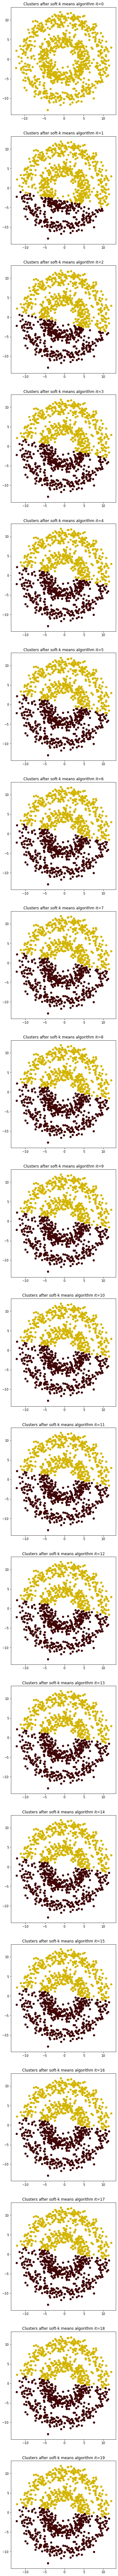

In [283]:
N = X.shape[0]
model = k_means(beta=1.0,N=N,epochs=20,num_of_clusters=2,data=X)
model.train(soft=True,plot=True)

The plots of iteration = 0, 2, 19 are shown as below. K-means algorithm does not correctly classify the two concentric circles. 

<br>
<img src="https://i.imgur.com/7f2ZJJz.png"  width="300" align="left"/>
<img src="https://i.imgur.com/2RTXKmC.png"  width="300" align="left"/>
<img src="https://i.imgur.com/MlAbTlV.png"  width="300" align="left"/>

### Dataset 2: elongated data

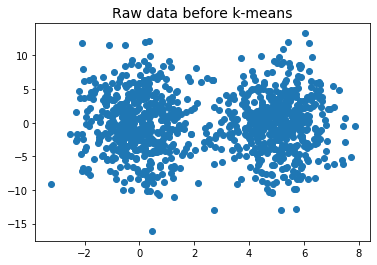

In [4]:
# a bivariate normal distribution with a covariance matrix [[1,0],[0,20]]
X = np.zeros((1000,2))
X[:500,:] = np.random.multivariate_normal([0,0],[[1,0],[0,20]],500)
X[500:,:] = np.random.multivariate_normal([5,0],[[1,0],[0,20]],500)
plt.scatter(X[:,0],X[:,1])
plt.title("Raw data before k-means",fontsize=14)
plt.show()

100%|██████████| 20/20 [00:01<00:00, 15.05it/s]


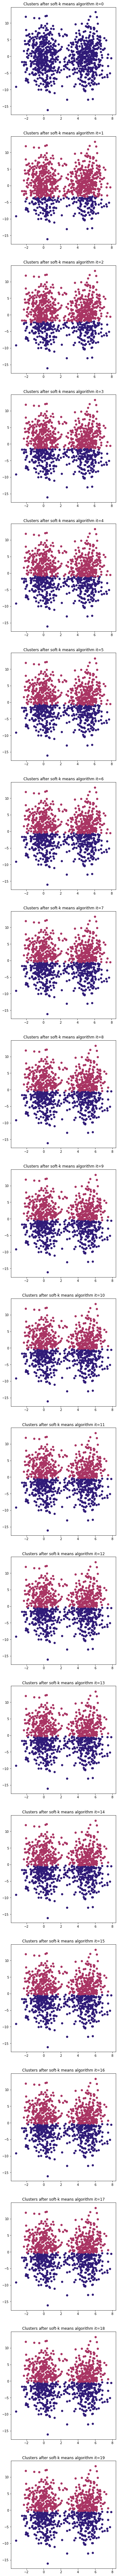

In [6]:
N = X.shape[0]
model = k_means(beta=1.0,N=N,epochs=20,num_of_clusters=2,data=X)
model.train(soft=True,plot=True)

The plots of iteration = 0, 2, 19 are shown as below. K-means algorithm does not correctly classify the two elongated clusters.

<br>
<img src="https://i.imgur.com/iZLaiKy.png"  width="300" align="left"/>
<img src="https://i.imgur.com/tXkk79x.png"  width="300" align="left"/>
<img src="https://i.imgur.com/IGgV5Su.png"  width="300" align="left"/>

### Dataset 3: dataset with largely unbalanced clusters

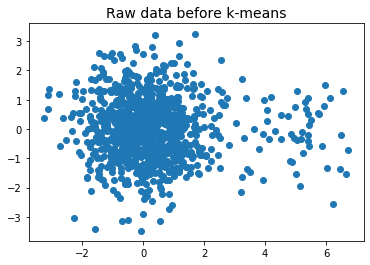

In [278]:
# the dataset has one cluster of 950 points and the other of 50 points
X = np.zeros((1000,2))
X[:950,:] = np.random.multivariate_normal([0,0],[[1,0],[0,1]],950)
X[950:,:] = np.random.multivariate_normal([5,0],[[1,0],[0,1]],50)
plt.scatter(X[:,0],X[:,1])
plt.title("Raw data before k-means",fontsize=14)
plt.show()

*A tip: np.random.multivariate_normal([0,0],[[1,0],[0,1]],500) is equivalent to np.random.randn(500,2)*








  0%|          | 0/20 [00:00<?, ?it/s]






 10%|█         | 2/20 [00:00<00:01, 16.82it/s]






 20%|██        | 4/20 [00:00<00:00, 16.76it/s]






 30%|███       | 6/20 [00:00<00:00, 16.44it/s]






 40%|████      | 8/20 [00:00<00:00, 16.42it/s]






 50%|█████     | 10/20 [00:00<00:00, 14.41it/s]






 60%|██████    | 12/20 [00:00<00:00, 14.65it/s]






 70%|███████   | 14/20 [00:00<00:00, 15.53it/s]






 80%|████████  | 16/20 [00:01<00:00, 15.72it/s]






 90%|█████████ | 18/20 [00:01<00:00, 16.57it/s]






100%|██████████| 20/20 [00:01<00:00, 16.36it/s]

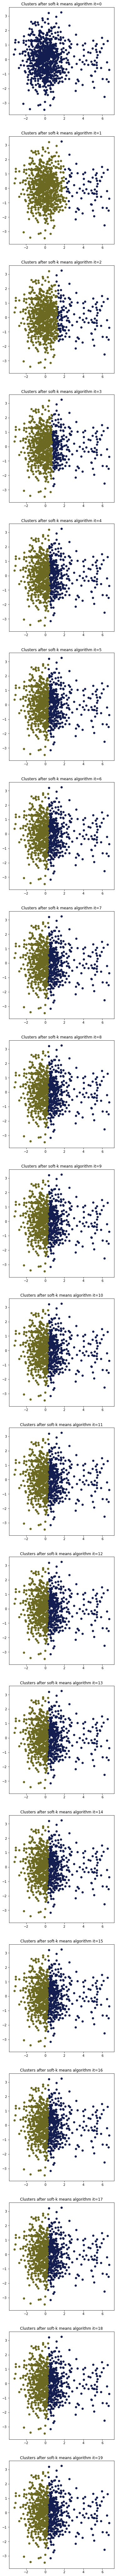

In [279]:
N = X.shape[0]
model = k_means(beta=1.0,N=N,epochs=20,num_of_clusters=2,data=X)
model.train(soft=True,plot=True)

The plots of iteration = 0, 2, 19 are shown as below. K-means algorithm does not correctly classify the two unbalanced clusters.

<br>
<img src="https://i.imgur.com/D7ecbtw.png"  width="300" align="left"/>
<img src="https://i.imgur.com/vvmAYuE.png"  width="300" align="left"/>
<img src="https://i.imgur.com/ieKm8VT.png"  width="300" align="left"/>

## Cluster analysis on NLP --- Word clusters/cloud

In [27]:
class NLP():
    
    def __init__(self):
        
        self.word_count = None
        self.sentences = None
        self.word_index = None
        self.word_doc = None
    
    def generate_stopwords(self,file):
        stopwords = []
        
        with open(file,'r') as f:
            lines = f.readlines()

        for line in lines:
            line = line.strip()
            line = line.lower()
            stopwords.append(line)     
        
        return stopwords
    
    def preprocess_data(self,files,stopwords):   
        word_count={}
        sentences = []
        regex="[-*={|\[]"
        lemmatizer = WordNetLemmatizer()
        print("Proprocessing data...")
        for file in files:
            with open(file,'r') as f:
                lines = f.readlines()
            for line in lines:
                line = line.strip()
                # Drop the sentences the beginning of which has weird characters
                if len(line)>0 and len(re.findall(regex,line[0]))==0:
                    line = line.lower()
                    # Substitute all non letter characters with whitespace, which only leaves actual words for training
                    line = re.sub('[^a-z0-9\']',' ',line)
                    words = line.split()
                    tokens=[]
                    count_for_stopwords = 0
                    # Make sure that after dropping the sentence by stopwords, we still have at least 2 words in 
                    # order to form a sentence
                    for w in words:   
                        w = lemmatizer.lemmatize(w)
                        if w in stopwords:
                            count_for_stopwords+=1
                    if len(words) - count_for_stopwords < 2:
                        continue

                    for w in words:
                        w = lemmatizer.lemmatize(w)
                        if w in stopwords:
                            continue
                        tokens.append(w)    
                        if w not in word_count:
                            word_count[w] = 0
                        word_count[w]+=1
                    sentences.append(tokens)
        print("Done.")
        self.word_count = word_count
        self.sentences = sentences
    
    def TF_IDF(self,M):
        
        word_count = self.word_count
        sentences = self.sentences
        most_freq = sorted(word_count.items(),key=lambda x: x[1],reverse=True)[:M]
        vocab = [x[0] for x in most_freq]
        word_index = {v:k for k,v in enumerate(vocab)}
        word_doc = np.zeros((len(vocab),len(sentences)))
        print("Generating TF-IDF matrix...")
        for word in vocab:
            c = 0
            for doc_indx,doc in enumerate(sentences):
                if word in doc:
                    c+=1
                for w in doc:       
                    if word == w:
                        word_doc[word_index[word],doc_indx]+=1  

            word_doc[word_index[word],:]/=c
        
        print("Done.")

        self.word_index = word_index
        self.word_doc = word_doc
        
    def TSNE(self,matrix):
        start_time = time.time()
        print("Running t-SNE... ")
        tsne = TSNE()
        Z = tsne.fit_transform(matrix)
        print("Took %s seconds to run t-SNE." % (time.time() - start_time))
        print("Done.")
        
        return Z

    def color_generator(self,num):
        
        e = ['a','b','c','d','e','f','0','1','2','3','4','5','6','7','8','9']
        colors = []
        
        for _ in range(num):
            hex_c = "#"+''.join([e[i] for i in np.random.choice(len(e),6)])
            colors.append(hex_c)
        
        return colors

   
    def save_tsne(self,savedir,Z):
        
        np.savez("%s/k_means_word_cloud_tsne.npz" % savedir,Z)
        
    def load_tsne(self,loaddir,x):
        
        npz = np.load('%s/k_means_word_cloud_tsne.npz' % loaddir)
    
        Z = npz['arr_0']
        
        return Z

        

Add a function for annotating every word in the word cloud.

In [41]:
def annotate(X,label,index_word_map,threshold=5.0):
    
    """
    This function helps to annotate each word appearing in the word cloud.
    
    """
    
    N, D = X.shape   
    # this array contains all the words that are already in the plot
    in_plot = np.zeros((N, D))

    for i,word_label in enumerate(label):

        # if the new word is too close (below the threshold) to the annotation texts of other already-existed words,
        # then move the annotation text of this new word a little bit by altering text location
        # x and y are the text location
        relocated = []
        x, y = X[i]

        for _ in range(3):
            # Retry relocating the annotation text for three times in a random way.
            for j in range(i):
                distance = np.array([x, y]) - in_plot[j]

                if distance.dot(distance) < threshold:
                    relocated.append(in_plot[j])

            if len(relocated)!=0:
                # relocate the annotation text
                x += (np.random.randn() + 0.5) * (1 if np.random.rand() < 0.5 else -1)
                y += (np.random.randn() + 0.5) * (1 if np.random.rand() < 0.5 else -1)

            else:    
                break

        in_plot[i] = (x, y)

        annotation = plt.annotate(
          s=index_word_map[word_label],
          xy=(X[i,0], X[i,1]),
          xytext=(x, y),
          arrowprops={
            'arrowstyle' : '->',
            'color' : 'black',
          }
        )

        annotation.set_fontsize(14)

We use a dataset of book titles to generate a word cloud.

In order to apply cluster analysis to the raw text of book titles, we firstly want to load the raw text data and do preprocessing. We filter the text data with common stopwords as well as lemmatize the text data. Then we want to create a Term Frequency - Inverse Dcoument Frequency (TF-IDF) matrix. After that, we apply t-SNE to do dimensionality reduction on TF-IDF matrix, and finally we run cluster analysis on the reduced matrix to generate the word cloud.

2500 most frequent words out of the raw text are chosen to generate the word cloud. And these 2500 words are set to be classified into 250 clusters. That is to say, for each cluster, there are about 10 words on average.

###  Preprocess data, generate TF-IDF matrix and apply t-SNE

In [29]:
nlp = NLP()
stopwords = nlp.generate_stopwords("./stopwords.txt")
files = ['./all_book_titles.txt']
nlp.preprocess_data(files,stopwords)
nlp.TF_IDF(M=2500)
word_index = nlp.word_index
word_doc = nlp.word_doc
index_word = {v:k for k,v in word_index.items()}
data = nlp.TSNE(word_doc)
N,D = data.shape

Proprocessing data...
Done.
Generating TF-IDF matrix...
Done.
Running t-SNE... 
Took 34.102762937545776 seconds to run t-SNE.
Done.


### Do cluster analysis

100%|██████████| 30/30 [05:39<00:00, 10.99s/it]


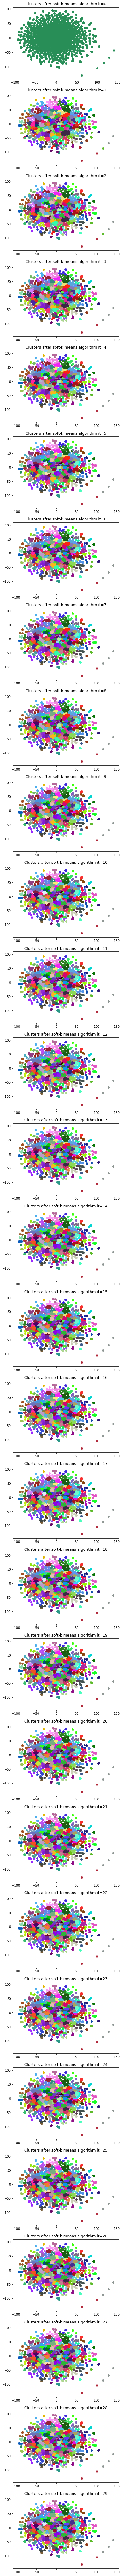

In [43]:
model = k_means(beta=1.0,N=N,epochs=30,num_of_clusters=250,data=data)
model.train(soft=True,plot=True)

Plot cost values for each epoch

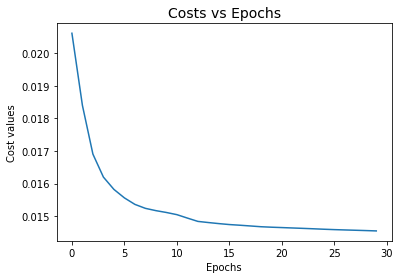

In [44]:
plt.plot(model.costs)
plt.xlabel("Epochs")
plt.ylabel("Cost values")
plt.title("Costs vs Epochs",fontsize=14)
plt.show()

Visualize clusters before and after k-means


<img src="https://i.imgur.com/Qx11Z6n.png"  width="600" align="center"/>
<img src="https://i.imgur.com/ERXBOan.png"  width="600" align="center"/>

Visualize word clusters

88it [00:00, 113.56it/s]


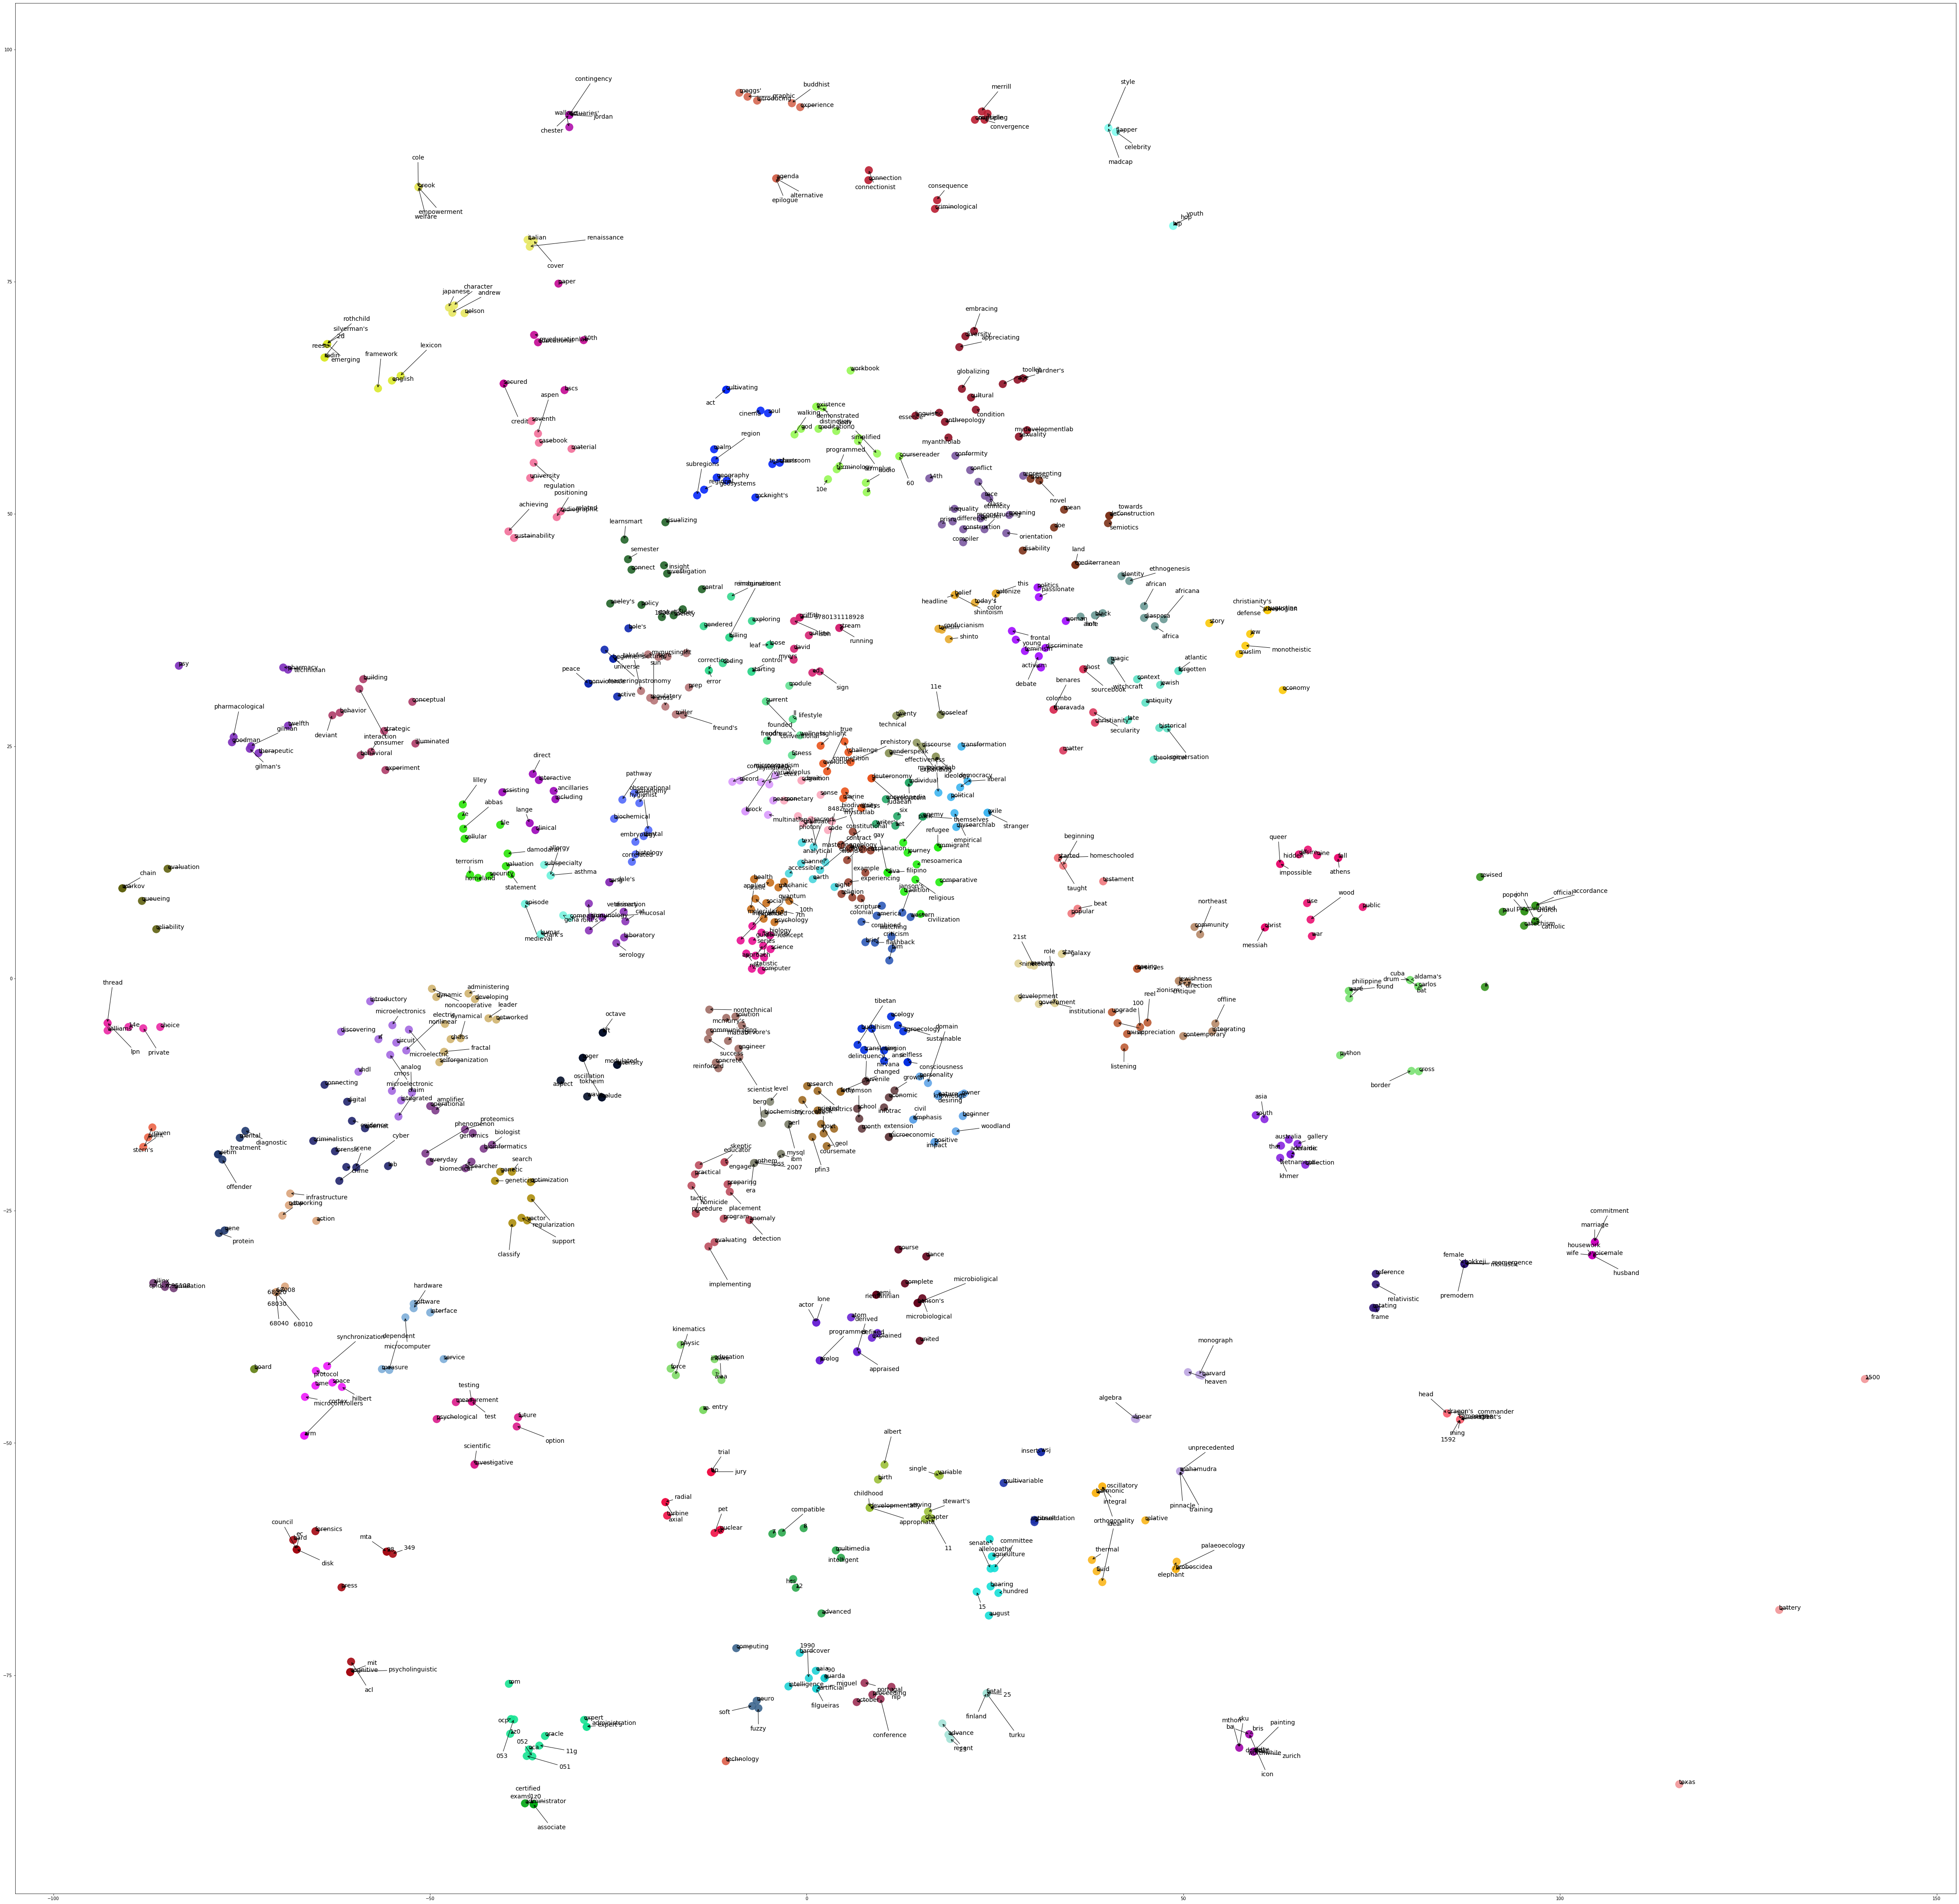

In [47]:
W = model.W
# Collect the indices of words of one cluster into one label list. And we have 200 label lists, which are all stored
# in the labels variable.
labels = [[] for _ in range(model.num_of_clusters)]
for i in range(W.shape[0]):
    indx = W[i,:].argmax()
    labels[indx].append(i)
    
plt.figure(figsize=(80.0, 80.0))
colors = nlp.color_generator(len(labels))
c = 0
# We can print out partial word cloud by adding an early stop
early_stop = 100
for num,label_indices in tqdm(enumerate(labels)):
    c+=1
    if len(label_indices) == 0:
        continue
    color = colors[num]
    plt.scatter(data[label_indices][:,0],data[label_indices][:,1],s=300,alpha=0.9,c=color)
    annotate(data[label_indices],label_indices,index_word)
    if c > early_stop:
        break
plt.savefig("./test.png")

 Let's view some results of the word cloud

**Terms about Biology**

<img src="https://i.imgur.com/YbR3aXO.png"  width="600" align="center"/>

**Terms about Physics**

<img src="https://i.imgur.com/QITl0CC.png"  width="600" align="center"/>

**Terms about regions**

<img src="https://i.imgur.com/R3uaV8o.png"  width="600" align="center"/>

**Terms about computer**

<img src="https://i.imgur.com/pUvXz5E.png"  width="600" align="center"/>

**Terms about Criminology**

<img src="https://i.imgur.com/e1UuCEk.png"  width="600" align="center"/>

**Terms about religions**

<img src="https://i.imgur.com/9JkeOtz.png"  width="600" align="center"/>